In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from pathlib import Path
import os, sys, time

import xarray as xr
from xorca.lib import load_xorca_dataset

### test interpolation vmodes
from xgcm import Grid
import itidenatl.utils as ut

In [2]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster()
client = Client(address=cluster)
client

Client Scheduler: tcp://127.0.0.1:34364 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


### define parameters

In [5]:
### define what to do, whic files to read, which variables, etc.

which_uv = "u" # "v"
chunks = {"x":-1, "y":100, "z":10}

scratch = Path(os.getenv("SCRATCHDIR"))
worksha = Path(os.getenv("WORKS"))
workdir = Path(os.getenv("WORK1"))

mean_file = workdir/"eNATL60_mean_grid_z.zarr"
grid_file = scratch/"mesh_mask_eNATL60_3.6.nc"
mode_file = worksha/"vmodes/vmodes_10.zarr"

out_file = mode_file.parent/mode_file.name.replace("vmodes", "phi_"+which_uv)

coords = {"{}maskutil".format(which_uv): "grid", 
           "e3{}".format(which_uv): "grid", 
           "depth_{}_3d".format(which_uv): "grid",
           "{}mask".format(which_uv): "grid",
          "depth_c": "mode"
          } 

### load and prepare data

In [10]:
# load grid file with xorca to make the grid
ds_g = load_xorca_dataset(data_files=[], aux_files=[grid_file],
                              decode_cf=True, model_config="nest"
                             )
grid = Grid(ds_g, periodic=False)
del ds_g

In [15]:
### create / organize dataset

keep_co = [k for k,v in coords.items() if v=="mode"]
chunks_tg = {d:chunks[d[0]] for d in ["x_r", "x_c", "y_r", "y_c", "z_c", "z_l"]}
chunks_tg.update({"mode":1})

# first the modes
ds = xr.open_zarr(mode_file).get(["phi"]).astype("float32")
ds = ds.reset_coords([c for c in ds.coords if c not in keep_co and c not in ds.dims], drop=True)
ds = ds.chunk({d:chunks_tg[d] for d in ds.dims if d in chunks_tg})

# then add coordinates
for c,f in coords.items():
    if f not in ["mode"]:
        laco = ut.open_one_coord(grid_file, chunks=chunks, varname=c)
        if len(laco.dims) > 2 and laco[c].dtype == "float64":
            laco = laco.astype("float32")
        ds = ds.assign_coords(laco)
        
### do the interpolation and persist some of the fields (persisting takes a few 10 seconds)
which_ax = "XYZ"["uvw".index(which_uv)]
mask, e3z, dep = which_uv+"mask", "e3"+which_uv, "depth_{}_3d".format(which_uv)

ds["phi"] = grid.interp(ds["phi"], which_ax, boundary="extend")\
            .chunk({which_ax.lower()+"_r":chunks[which_ax.lower()]})

ds = ds.drop_dims(which_ax.lower()+"_c")

### compute grid metric correction. WARNING Do not execute twice in a row!
ds = ds.assign_coords(hbot=ds[e3z].where(ds[mask]).sum("z_c"))
sshm = xr.open_zarr(mean_file).sossheig
sshm = grid.interp(sshm, which_ax, boundary="extend")
ds["sossheig"] = sshm.chunk({d:chunks_tg[d] for d in sshm.dims})
lacorr = (1. + ds.sossheig / ds.hbot).persist()
### correct grid metric
ds[e3z] = (ds[e3z] * lacorr).astype("float32")
ds = ds.rename({e3z:e3z+"_m"})
e3z += "_m"
### correct mean depth
ds[dep] = (ds[dep] * lacorr + ds.sossheig).astype("float32")
ds = ds.rename({dep:dep.replace("3d","m")})
dep = dep.replace("3d","m")

ds

<xarray.Dataset>
Dimensions:    (mode: 11, x_r: 8354, y_c: 4729, z_c: 300)
Coordinates:
  * x_r        (x_r) float64 1.5 2.5 3.5 4.5 ... 8.352e+03 8.354e+03 8.354e+03
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
    umaskutil  (y_c, x_r) int8 dask.array<chunksize=(100, 8354), meta=np.ndarray>
    e3u_m      (z_c, y_c, x_r) float32 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    depth_u_m  (z_c, y_c, x_r) float32 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    umask      (z_c, y_c, x_r) int8 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    hbot       (y_c, x_r) float32 dask.array<chunksize=(100, 8354), meta=np.ndarray>
Data variables:
    phi        (y_c, x_r, z_c, mode) float32 dask.array<chunksize=(100, 8354, 10, 1), meta=np.ndarray>
    sossheig   (y_c, x_r) float64 dask.array<chunksize=(100, 8354), meta=np.ndarray>
Attributes:
    N2name:                   bvf
    corr_N:                   True
    eig_sigma:                0.1
    first_order_formulation:  False
    free_surf:                True
    g:                        9.81
    nmodes:                   10
    siz_sparse:               30
    zc_name:                  z_c
    zl_name:                  z_l

### create zarr archive, compute and store

In [7]:
### create empty zarr archive
ds.to_zarr(out_file, mode="w", compute=False, consolidated=True, safe_chunks=False)

Delayed('_finalize_store-0c5fd6a6-c162-4ca1-b783-0b3cf56fc573')

In [8]:
### write coordinates
ds.drop("phi").to_zarr(out_file, mode="a", compute=True, safe_chunks=False)

In [10]:
### reload and persist tmask and umask, rewrite norm
ds_re = xr.open_zarr(out_file)
ds_re

<xarray.Dataset>
Dimensions:    (mode: 11, x_r: 8354, y_c: 4729, z_c: 300)
Coordinates:
    e3u_m      (z_c, y_c, x_r) float32 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    hbot       (y_c, x_r) float32 dask.array<chunksize=(100, 8354), meta=np.ndarray>
  * mode       (mode) int64 0 1 2 3 4 5 6 7 8 9 10
    umask      (z_c, y_c, x_r) int8 dask.array<chunksize=(10, 100, 8354), meta=np.ndarray>
    umaskutil  (y_c, x_r) int8 dask.array<chunksize=(100, 8354), meta=np.ndarray>
  * x_r        (x_r) float64 1.5 2.5 3.5 4.5 ... 8.352e+03 8.354e+03 8.354e+03
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
Data variables:
    phi        (y_c, x_r, z_c, mode) float32 dask.array<chunksize=(100, 8354, 10, 1), meta=np.ndarray>
    sossheig   (y_c, x_r) float64 dask.array<chunksize=(100, 8354), meta=np.ndarray>
Attributes:
    N2name:                   bvf
    corr_N:                   True
    eig_sigma:                0.1
    first_order_formulation:  False
    free_surf:                True
    g:                        9.81
    nmodes:                   10
    siz_sparse:               30
    zc_name:                  z_c
    zl_name:                  z_l

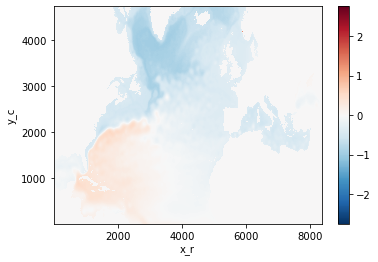

In [11]:
### just checking: this should look like SSH
(ds_re.e3u_m.where(ds_re.umask).sum("z_c") - ds_re.hbot).plot()

In [12]:
client.restart()

Client Scheduler: tcp://127.0.0.1:39019 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [13]:
da_mask = ds_re[mask].reset_coords(drop=True).persist()
da_e3z = ds_re[e3z].reset_coords(drop=True).persist()

ds = ds.reset_coords(drop=True)
ds["norm"] = (ds.phi**2 * da_e3z).where(da_mask).sum("z_c")
ds

<xarray.Dataset>
Dimensions:   (mode: 11, x_r: 8354, y_c: 4729, z_c: 300)
Coordinates:
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 ... 8.352e+03 8.354e+03 8.354e+03
  * mode      (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
Data variables:
    phi       (y_c, x_r, z_c, mode) float32 dask.array<chunksize=(100, 8354, 10, 1), meta=np.ndarray>
    sossheig  (y_c, x_r) float64 dask.array<chunksize=(100, 8354), meta=np.ndarray>
    norm      (y_c, x_r, mode) float32 dask.array<chunksize=(100, 8354, 1), meta=np.ndarray>
Attributes:
    N2name:                   bvf
    corr_N:                   True
    eig_sigma:                0.1
    first_order_formulation:  False
    free_surf:                True
    g:                        9.81
    nmodes:                   10
    siz_sparse:               30
    zc_name:                  z_c
    zl_name:                  z_l

In [14]:
ds.get(["norm"]).to_zarr(out_file, mode="a", compute=False, safe_chunks=False)

Delayed('_finalize_store-02eb3e90-0bd9-47bd-9d3f-06ba55f1687f')

In [15]:
client.rebalance()

In [16]:
### gor for it: phi and norm at the same time
# ca swap beaucoup mais ça passe (sur visu)
region = {d:slice(0,None) for d in ds.phi.dims}
print("computing and storing by mode")
for imod in range(ds.mode.size):
    tmes = time.time()
    slim = slice(imod,imod+1)
    region["mode"] = slim
    sds = ds.isel(mode=slim)#.get(["phi", "norm"]).reset_coords(drop=True)
    sds.to_zarr(out_file, mode="a", compute=True, safe_chunks=False, region=region)
    print("{} ({:.1f} s)".format(imod,time.time()-tmes), end="; ")
    del sds

computing and storing by mode
0 (82.2 s); 1 (88.0 s); 2 (91.7 s); 3 (108.1 s); 4 (81.3 s); 5 (93.4 s); 6 (93.6 s); 7 (115.6 s); 8 (96.5 s); 9 (90.1 s); 10 (108.7 s); 

### check result

In [4]:
### check result
ds_re = xr.open_zarr(out_file)
ds_re

,Array,Chunk
Bytes,44.15 GiB,31.87 MiB
Shape,"(300, 4729, 8354)","(10, 100, 8354)"
Count,1441 Tasks,1440 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,11.04 GiB,7.97 MiB
Shape,"(300, 4729, 8354)","(10, 100, 8354)"
Count,1441 Tasks,1440 Chunks
Type,int8,numpy.ndarray
,Array,Chunk


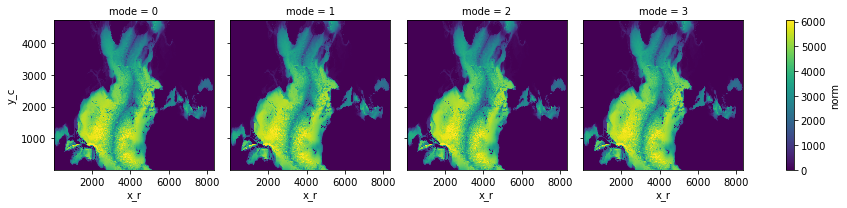

In [6]:
ds_re.norm.isel(mode=slice(0,4)).plot(col="mode")